### This notebook looks at the communicability within and across ntwx with and without SC lesions 

#### The code for communicability, navigation, shortest path are courtesy of Caio Seguin and the Brain Connectivity Toolbox. 
#### They were originally written in Matlab and translated to python by Chat-GPT. 
#### All these functions exist in a script called `communicability_functions.py`
#### See this link for the orginal Matlab versions of the functions (the functions are in the `fcn` folder): https://github.com/brain-networks/local_scfc/tree/main

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be done as an average for 200 subjects.
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
from collections import Counter

In [5]:
import pickle

In [123]:
from communicability_functions import communicability_wei, distance_wei_floyd, retrieve_shortest_path

In [7]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [8]:
import re

In [9]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [10]:
Wts_Path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

In [11]:
def load_wts(sub_id):

    _df = pd.read_csv(Wts_Path + '/{0}/{0}_new_atlas_Yeo.nii.csv'.format(sub_id), delimiter=' ',header=None)
    df_trimmed = _df.iloc[:-31, :-31]
    np_array = df_trimmed.values
    sc_mtx = np_array + np_array.T # --> Symmetric

    pre_laplachian_HCP_SC = sc_mtx.copy()

    SC = pre_laplachian_HCP_SC.copy()
    sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))
    
    return pre_laplachian_HCP_SC

In [12]:
%%time
all_subs_pre_lap_SC = []

for i in range(len(sub_list)):
    pre_lap_SC = load_wts(sub_list[i])
    all_subs_pre_lap_SC.append(pre_lap_SC)

CPU times: user 6.88 s, sys: 31.6 ms, total: 6.91 s
Wall time: 8.11 s


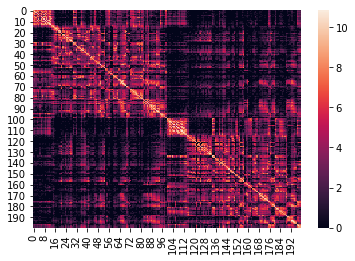

In [13]:
sns.heatmap(np.log1p(all_subs_pre_lap_SC[0]))

In [14]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [15]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [16]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 59.6 s, sys: 388 ms, total: 1min
Wall time: 1min 3s


In [17]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.38 s, sys: 88.3 ms, total: 1.46 s
Wall time: 1.46 s


In [18]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [19]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [20]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
# all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
# all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
# all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
# all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
# all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
# all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
# all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
#     all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
#     all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
#     all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
#     all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
#     all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
#     all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
#     ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
#     all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 1min 19s, sys: 1.28 s, total: 1min 21s
Wall time: 1min 36s


In [21]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_sommot_lesion,
                        all_subs_dorsattn_lesion,all_subs_ventattn_lesion,
                        all_subs_limbic_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

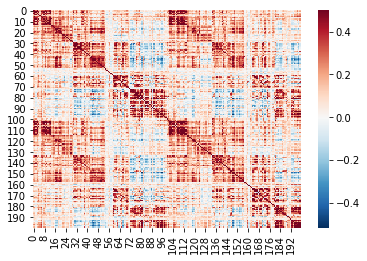

In [22]:
sns.heatmap(all_subs_emp_fc_mat[4], cmap='RdBu_r',center=0,vmax=0.5)

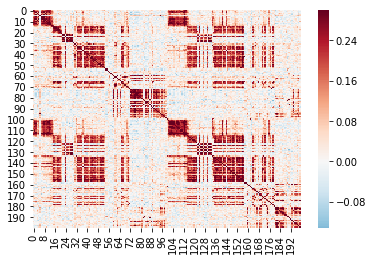

In [23]:
sns.heatmap(all_subs_og_whobpyt[4], cmap='RdBu_r',center=0,vmax=0.3)

In [24]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [25]:
# corrs_list

In [26]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [27]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

###  get the distance mtx

In [28]:
# from Davide's OHBM 2023 educational course google colab: 
# https://colab.research.google.com/drive/10irtJ_htqaicwL5r3DJOxu1vfQpAyYbK#scrollTo=AYDc8nuQAIjq

In [29]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))


coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms

distance = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
    for roi2 in range(coords.shape[0]):
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))




--> `distance` is distance mtx

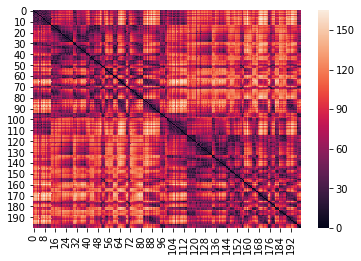

In [30]:
sns.heatmap(distance)

In [34]:
import scipy.linalg
import scipy.sparse


In [35]:
def communicability_wei_v2(CIJ):
    
    """
    Calculate communicability for a weighted connection matrix CIJ.
    
    Inputs:
    CIJ - weighted connection matrix
    
    Output:
    F - communicability matrix
    
    Note: This time, we don't normalize using scipy.linalg.expm(S^(1/2)*SC*S^(1/2)),
    where S is the diagonal matrix. 
    This is because pre-/post- SC lesion, the diagonals are different for the different SCs. 
    """
    
    N = CIJ.shape[0]
    min_val = np.min(CIJ)
    max_val = np.max(CIJ)
    scaled_matrix = (CIJ - min_val) / (max_val - min_val)
    
    F = scipy.linalg.expm(scaled_matrix)
    F = F * np.logical_not(np.eye(N))
    
    return F


## Communicability

In [36]:
# intact sc

In [37]:
%%time
all_subs_communicability_sc = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    communicability_sc = communicability_wei_v2(sub_sc)
    all_subs_communicability_sc.append(communicability_sc)
    del communicability_sc

CPU times: user 3.55 s, sys: 99.2 ms, total: 3.65 s
Wall time: 3.65 s


In [38]:
def structurally_isolate_func_ntwx(a,b,c,d, sc):
    
    modified_matrix = sc.copy()

    modified_matrix[a:b,0:a] = 0
    modified_matrix[a:b,b:c] = 0
    modified_matrix[a:b,d:200] = 0
    modified_matrix[c:d,0:a] = 0
    modified_matrix[c:d,b:c] = 0
    modified_matrix[c:d,d:200] = 0

    modified_matrix[0:a,a:b] = 0
    modified_matrix[b:c,a:b] = 0
    modified_matrix[d:200,a:b] = 0
    modified_matrix[0:a,c:d] = 0
    modified_matrix[b:c,c:d] = 0
    modified_matrix[d:200,c:d] = 0
    
#     modified_matrix = modified_matrix/np.linalg.norm(modified_matrix)
    
    return modified_matrix

In [39]:
# ntwx_labels_idxs = [
# [0,14,100,115],
# [14,30,115,134],
# [30,43,134,147],
# [43,54,147,158],
# [54,60,158,164],
# [60,73,164,181],
# [73,100,181,200]]

In [40]:
%%time
all_subs_sc_vis_lesion = []
all_subs_sc_smt_lesion = []
all_subs_sc_dan_lesion = []
all_subs_sc_van_lesion = []
all_subs_sc_lim_lesion = []
all_subs_sc_fpn_lesion = []
all_subs_sc_dmn_lesion = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    
    vis_lesion_sc = structurally_isolate_func_ntwx(0,14,100,115, sub_sc)
    all_subs_sc_vis_lesion.append(vis_lesion_sc)
    del vis_lesion_sc
    
    smt_lesion_sc = structurally_isolate_func_ntwx(14,30,115,134, sub_sc)
    all_subs_sc_smt_lesion.append(smt_lesion_sc)
    del smt_lesion_sc
    
    dan_lesion_sc = structurally_isolate_func_ntwx(30,43,134,147, sub_sc)
    all_subs_sc_dan_lesion.append(dan_lesion_sc)
    del dan_lesion_sc
    
    van_lesion_sc = structurally_isolate_func_ntwx(43,54,147,158, sub_sc)
    all_subs_sc_van_lesion.append(van_lesion_sc)
    del van_lesion_sc
    
    lim_lesion_sc = structurally_isolate_func_ntwx(54,60,158,164, sub_sc)
    all_subs_sc_lim_lesion.append(lim_lesion_sc)
    del lim_lesion_sc
    
    fpn_lesion_sc = structurally_isolate_func_ntwx(60,73,164,181, sub_sc)
    all_subs_sc_fpn_lesion.append(fpn_lesion_sc)
    del fpn_lesion_sc
    
    dmn_lesion_sc = structurally_isolate_func_ntwx(73,100,181,200, sub_sc)
    all_subs_sc_dmn_lesion.append(dmn_lesion_sc)
    del dmn_lesion_sc

CPU times: user 91.2 ms, sys: 190 ms, total: 281 ms
Wall time: 279 ms


In [41]:
# lesion sc

In [42]:
%%time

all_subs_communicability_sc_vis_lesion = []
all_subs_communicability_sc_smt_lesion = []
all_subs_communicability_sc_dan_lesion = []
all_subs_communicability_sc_van_lesion = []
all_subs_communicability_sc_lim_lesion = []
all_subs_communicability_sc_fpn_lesion = []
all_subs_communicability_sc_dmn_lesion = []


for i in range(200):
    
    vis_communicability_sc = communicability_wei_v2(all_subs_sc_vis_lesion[i])
    all_subs_communicability_sc_vis_lesion.append(vis_communicability_sc)
    del vis_communicability_sc

    
    smt_communicability_sc = communicability_wei_v2(all_subs_sc_smt_lesion[i])
    all_subs_communicability_sc_smt_lesion.append(smt_communicability_sc)
    del smt_communicability_sc

    
    dan_communicability_sc = communicability_wei_v2(all_subs_sc_dan_lesion[i])
    all_subs_communicability_sc_dan_lesion.append(dan_communicability_sc)
    del dan_communicability_sc

    
    van_communicability_sc = communicability_wei_v2(all_subs_sc_van_lesion[i])
    all_subs_communicability_sc_van_lesion.append(van_communicability_sc)
    del van_communicability_sc

    
    lim_communicability_sc = communicability_wei_v2(all_subs_sc_lim_lesion[i])
    all_subs_communicability_sc_lim_lesion.append(lim_communicability_sc)
    del lim_communicability_sc
    

    fpn_communicability_sc = communicability_wei_v2(all_subs_sc_fpn_lesion[i])
    all_subs_communicability_sc_fpn_lesion.append(fpn_communicability_sc)
    del fpn_communicability_sc
    

    dmn_communicability_sc = communicability_wei_v2(all_subs_sc_dmn_lesion[i])
    all_subs_communicability_sc_dmn_lesion.append(dmn_communicability_sc)
    del dmn_communicability_sc

CPU times: user 25.1 s, sys: 313 ms, total: 25.4 s
Wall time: 25.4 s


## WITHIN NETWORKS

In [43]:
def within_ntwx_SC(SC, a,b,c,d):
    
    ntwx_only_lh = SC[a:b, a:b]
    ntwx_only_rh = SC[c:d, c:d]

    ntwx_only_lhrh = SC[a:b, c:d]
    ntwx_only_rhlh = SC[c:d, a:b]
    
    mean_sc = ((np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh))/2 + (np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/2)
    
    return mean_sc

In [44]:
def within_ntwx_SC_communicability(SC):
    
    # lesion (DMN) whobpyt

    lesion_vis_sc_comm_all_subs = []
    lesion_smt_sc_comm_all_subs = []
    lesion_dan_sc_comm_all_subs = []
    lesion_van_sc_comm_all_subs = []
    lesion_lim_sc_comm_all_subs = []
    lesion_fpn_sc_comm_all_subs = []
    lesion_dmn_sc_comm_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = within_ntwx_SC(SC[i], 0, 14, 100, 115)
        lesion_vis_sc_comm_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = within_ntwx_SC(SC[i], 14, 30, 115, 134)
        lesion_smt_sc_comm_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = within_ntwx_SC(SC[i], 30, 43, 134, 147)
        lesion_dan_sc_comm_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = within_ntwx_SC(SC[i], 43, 54, 147, 158)
        lesion_van_sc_comm_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = within_ntwx_SC(SC[i], 54, 60, 158, 164)
        lesion_lim_sc_comm_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = within_ntwx_SC(SC[i], 60, 73, 164, 181)
        lesion_fpn_sc_comm_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = within_ntwx_SC(SC[i], 73, 100, 181, 200)
        lesion_dmn_sc_comm_all_subs.append(ntwx_lesion_temp_dmn)


    lesion_vis_sc_comm_all_subs_mean = np.mean(lesion_vis_sc_comm_all_subs)
    lesion_smt_sc_comm_all_subs_mean = np.mean(lesion_smt_sc_comm_all_subs)
    lesion_dan_sc_comm_all_subs_mean = np.mean(lesion_dan_sc_comm_all_subs)
    lesion_van_sc_comm_all_subs_mean = np.mean(lesion_van_sc_comm_all_subs)
    lesion_lim_sc_comm_all_subs_mean = np.mean(lesion_lim_sc_comm_all_subs)
    lesion_fpn_sc_comm_all_subs_mean = np.mean(lesion_fpn_sc_comm_all_subs)
    lesion_dmn_sc_comm_all_subs_mean = np.mean(lesion_dmn_sc_comm_all_subs)


    ntwx_lesion_means_all_subs = [lesion_vis_sc_comm_all_subs,lesion_smt_sc_comm_all_subs,
                                  lesion_dan_sc_comm_all_subs,lesion_van_sc_comm_all_subs,
                                  lesion_lim_sc_comm_all_subs,lesion_fpn_sc_comm_all_subs,
                                  lesion_dmn_sc_comm_all_subs]
    
    ntwx_lesion_whobpyt_means = [lesion_vis_sc_comm_all_subs_mean,lesion_smt_sc_comm_all_subs_mean,
                                 lesion_dan_sc_comm_all_subs_mean,lesion_van_sc_comm_all_subs_mean,
                                 lesion_lim_sc_comm_all_subs_mean,lesion_fpn_sc_comm_all_subs_mean,
                                 lesion_dmn_sc_comm_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means, ntwx_lesion_means_all_subs

In [45]:
intact_sc_comm_means, intact_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc)

vis_lesion_sc_comm_means, vis_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_vis_lesion)
smt_lesion_sc_comm_means, smt_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_smt_lesion)
dan_lesion_sc_comm_means, dan_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_dan_lesion)
van_lesion_sc_comm_means, van_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_van_lesion)
lim_lesion_sc_comm_means, lim_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_lim_lesion)
fpn_lesion_sc_comm_means, fpn_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_fpn_lesion)
dmn_lesion_sc_comm_means, dmn_lesion_sc_comm_all_subs = within_ntwx_SC_communicability(all_subs_communicability_sc_dmn_lesion)

In [46]:
len(vis_lesion_sc_comm_all_subs[0])

200

In [47]:
all_sc_comm_means = [intact_sc_comm_means,
vis_lesion_sc_comm_means,
smt_lesion_sc_comm_means,
dan_lesion_sc_comm_means,
van_lesion_sc_comm_means,
lim_lesion_sc_comm_means,
fpn_lesion_sc_comm_means,
dmn_lesion_sc_comm_means]

In [ ]:
for i in range(len(all_sc_comm_means)):
    
    all_sc_comm_means[i] = [np.round(val,6) for val in all_sc_comm_means[i]]

In [ ]:
for i in range(len(all_sc_comm_means)):
    
    all_sc_comm_means[i] = [val*10 for val in all_sc_comm_means[i]]

In [48]:
# Define the column labels
column_labels = ['vis', 'smt', 'dan', 'van', 'lim', 'fpn', 'dmn']

# Create a list of lists with the data
data = all_sc_comm_means.copy()

# Define the row labels
row_labels = ['intact sc', 'vis lesion', 'smt lesion', 'dan lesion', 'van lesion', 'lim lesion', 'fpn lesion', 'dmn lesion']

# Create a Pandas DataFrame
df = pd.DataFrame(data, columns=column_labels, index=row_labels)

In [49]:
df

,vis,smt,dan,van,lim,fpn,dmn
intact sc,0.071524,0.012620,0.008466,0.007037,0.006800,0.009154,0.011453
vis lesion,0.070701,0.012618,0.008321,0.007033,0.006729,0.009140,0.011402
smt lesion,0.071518,0.012145,0.008277,0.006744,0.006799,0.009125,0.011428
dan lesion,0.071034,0.012452,0.007581,0.006912,0.006746,0.008991,0.011342
van lesion,0.071512,0.012360,0.008365,0.006178,0.006792,0.008955,0.011255
lim lesion,0.071458,0.012619,0.008456,0.007034,0.006370,0.009127,0.011391
fpn lesion,0.071467,0.012583,0.008190,0.006872,0.006702,0.008097,0.011029
dmn lesion,0.071303,0.012589,0.008246,0.006705,0.006585,0.008463,0.010629


In [50]:
type(all_sc_comm_means)

list

In [51]:
# print(intact_sc_comm_means)
# print(vis_lesion_sc_comm_means)
# print(smt_lesion_sc_comm_means)
# print(dan_lesion_sc_comm_means)
# print(van_lesion_sc_comm_means)
# print(lim_lesion_sc_comm_means)
# print(fpn_lesion_sc_comm_means)
# print(dmn_lesion_sc_comm_means)

In [50]:
ntwx_labels = ['Vis','SomMot', 'DorsAttn', 'VentAttn', 'Limbic','FPN','DMN']

In [51]:
def stats_func(all_subs):
    _df = pd.DataFrame(all_subs,index=ntwx_labels)
    _df = _df.T
    

### bar plots

In [52]:
Ntwx = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [96]:
intact_sc_comm_all_subs[0]
# vis_lesion_sc_comm_all_subs

200

In [ ]:
plt.plot()

In [110]:
ntwx = 1

(0, 0.035)

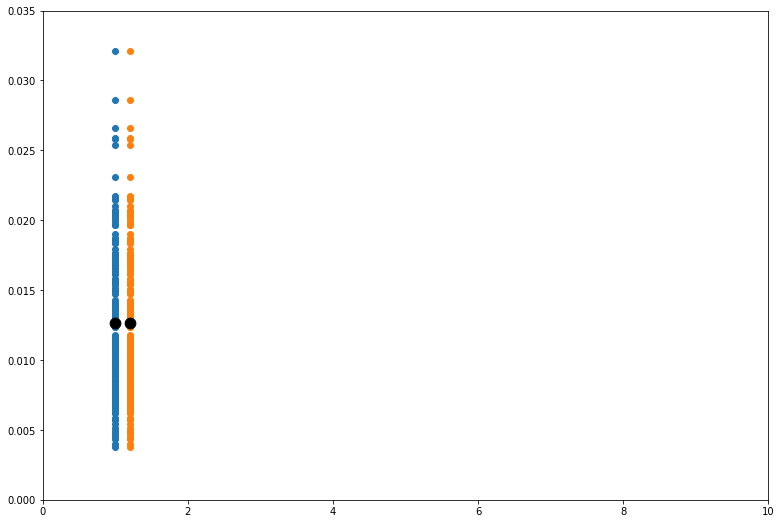

In [114]:
x = [1]*200
x1 = [1.2]*200
fig, ax = plt.subplots(figsize=(13,9))
intact_mean = np.mean(intact_sc_comm_all_subs[ntwx])
lesion_mean = np.mean(vis_lesion_sc_comm_all_subs[ntwx])
plt.scatter(x,intact_sc_comm_all_subs[ntwx])
plt.scatter(x1,vis_lesion_sc_comm_all_subs[ntwx])
plt.scatter(x[0],intact_mean,color='k',s=115.0)
plt.scatter(x1[0],lesion_mean,color='k',s=115.0)
plt.xlim([0,10])
plt.ylim([0,0.035])

In [112]:
intact_mean

0.012619579454140661

In [113]:
lesion_mean

0.012617922118558184

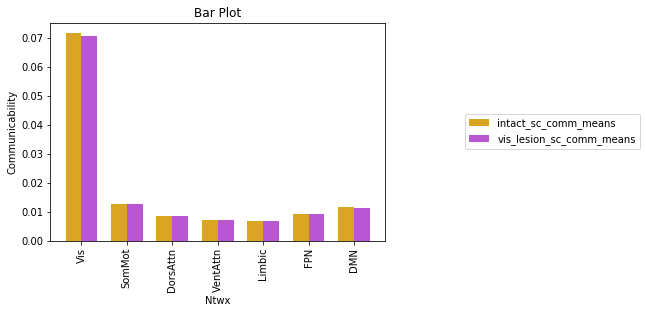

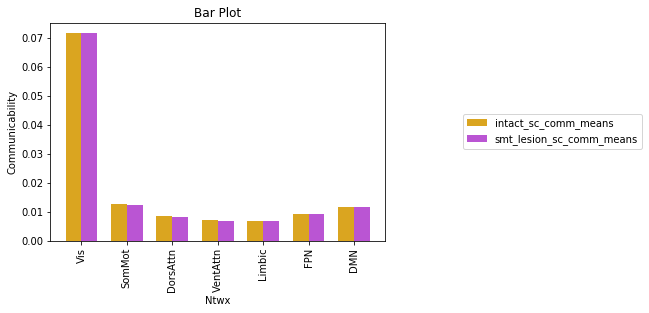

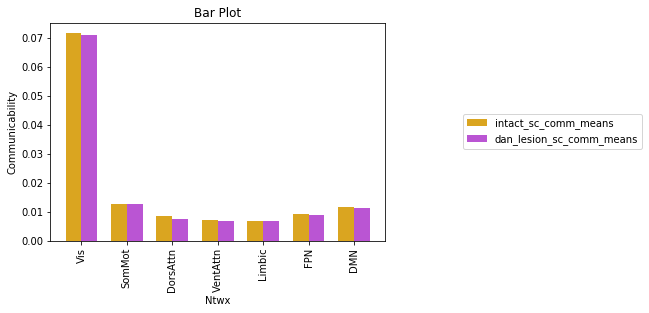

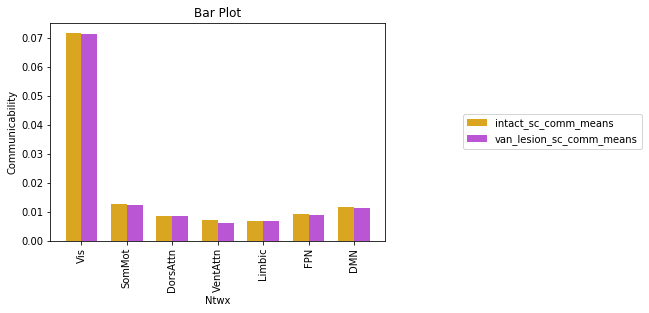

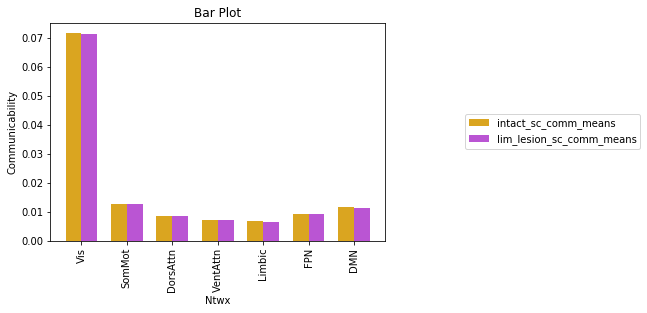

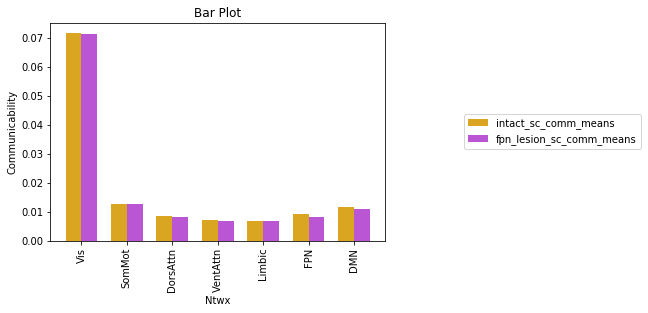

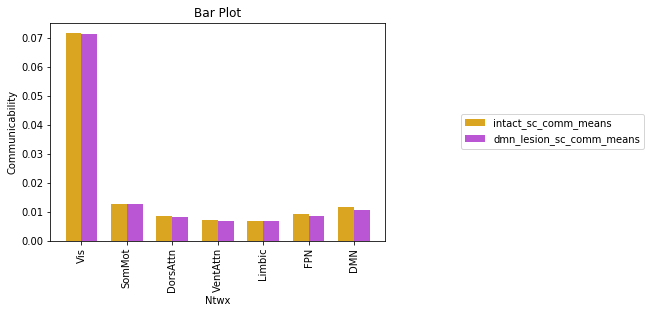

In [124]:
# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], vis_lesion_sc_comm_means, width, label='vis_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### Sommot

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], smt_lesion_sc_comm_means, width, label='smt_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### Dorsattn

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], dan_lesion_sc_comm_means, width, label='dan_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### Ventattn

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], van_lesion_sc_comm_means, width, label='van_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### Limbic

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], lim_lesion_sc_comm_means, width, label='lim_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### FPN

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], fpn_lesion_sc_comm_means, width, label='fpn_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### DMN lesion

# Creating the bar plot
x = range(len(intact_sc_comm_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, intact_sc_comm_means, width, label='intact_sc_comm_means',color='goldenrod')
rects2 = ax.bar([i + width for i in x], dmn_lesion_sc_comm_means, width, label='dmn_lesion_sc_comm_means',color='mediumorchid')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Communicability')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

In [ ]:
# Dan's advice:
# box plots
# a dot, with a confidence/error bar (std dev)

In [125]:
i = 1
list1 = [x*1 for x in intact_sc_comm_all_subs[i]]

list2 = [x*1 for x in vis_lesion_sc_comm_all_subs[i]]

In [126]:
from scipy.stats import wilcoxon


In [127]:
statistic, p_value = wilcoxon(list1, list2)

# Output the test statistic and p-value
print("Wilcoxon Test Statistic:", statistic)
print("P-Value:", p_value)

Wilcoxon Test Statistic: 0.0
P-Value: 1.4361464127613523e-34


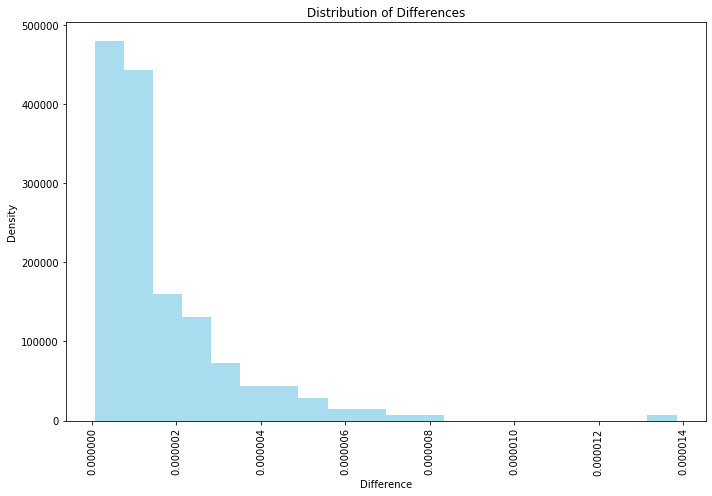

In [121]:
# Calculate the differences between the two lists
differences = np.array(list1) - np.array(list2)

# Calculate the paired t statistic
t_statistic, _ = stats.ttest_rel(list1, list2)

# Create a plot
plt.figure(figsize=(10, 7))

# Plot the differences
#     plt.subplot(1, 2, 1)
plt.hist(differences, bins=20, color='skyblue', alpha=0.7, density=True)
plt.title("Distribution of Differences")
plt.xlabel("Difference")
plt.ylabel("Density")
plt.xticks(rotation=90)

#     # Plot the paired t statistic
#     plt.subplot(1, 2, 2)
#     plt.bar([0], [t_statistic], color='orange', alpha=0.7)
#     plt.title("Paired t Statistic")
#     plt.xlabel("Effect Size")

plt.tight_layout()
plt.show()

In [122]:
print(t_statistic)

13.49261740831238


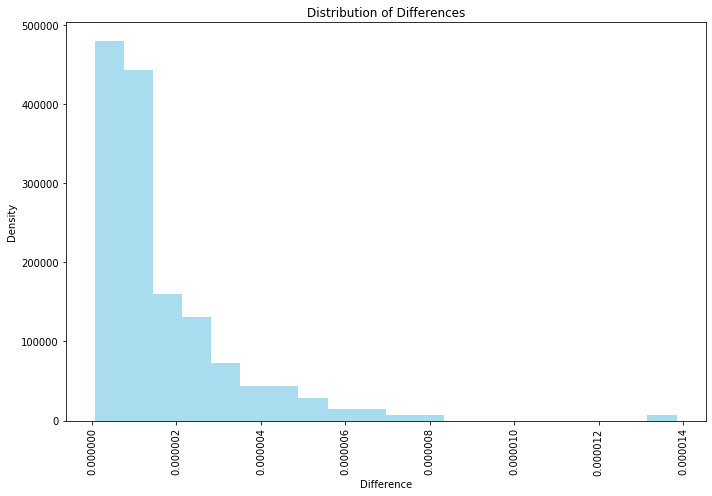

In [120]:
for i in range(7):
    list1 = [x*1 for x in intact_sc_comm_all_subs[i]]

    list2 = [x*1 for x in vis_lesion_sc_comm_all_subs[i]]

    # Calculate the differences between the two lists
    differences = np.array(list1) - np.array(list2)

    # Calculate the paired t statistic
    t_statistic, _ = stats.ttest_rel(list1, list2)

    # Create a plot
    plt.figure(figsize=(10, 7))

    # Plot the differences
#     plt.subplot(1, 2, 1)
    plt.hist(differences, bins=20, color='skyblue', alpha=0.7, density=True)
    plt.title("Distribution of Differences")
    plt.xlabel("Difference")
    plt.ylabel("Density")
    plt.xticks(rotation=90)

#     # Plot the paired t statistic
#     plt.subplot(1, 2, 2)
#     plt.bar([0], [t_statistic], color='orange', alpha=0.7)
#     plt.title("Paired t Statistic")
#     plt.xlabel("Effect Size")

    plt.tight_layout()
    plt.show()

## BETWEEN NTWX

In [54]:
# mean_sc = ((np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh))/2 + (np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/2)


In [55]:
def between_ntwx_only_sc(sc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = sc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = sc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_smt = sc[sub][a:b, 14:30]
    lh_ntwx_to_rh_smt = sc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dan = sc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dan = sc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_van = sc[sub][a:b, 43:54]
    lh_ntwx_to_rh_van = sc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_lim = sc[sub][a:b, 54:60]
    lh_ntwx_to_rh_lim = sc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = sc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = sc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = sc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = sc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = sc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = sc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_smt = sc[sub][c:d, 14:30]
    rh_ntwx_to_rh_smt = sc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dan = sc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dan = sc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_van = sc[sub][c:d, 43:54]
    rh_ntwx_to_rh_van = sc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_lim = sc[sub][c:d, 54:60]
    rh_ntwx_to_rh_lim = sc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = sc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = sc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = sc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = sc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_sc = ((np.mean(lh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/2 + (np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis))/2)#/4
    mean_ntwx_to_smt_sc = ((np.mean(lh_ntwx_to_lh_smt) + np.mean(rh_ntwx_to_rh_smt))/2 + (np.mean(lh_ntwx_to_rh_smt) + np.mean(rh_ntwx_to_lh_smt))/2)#/4
    mean_ntwx_to_dan_sc = ((np.mean(lh_ntwx_to_lh_dan) + np.mean(rh_ntwx_to_rh_dan))/2 + (np.mean(lh_ntwx_to_rh_dan) + np.mean(rh_ntwx_to_lh_dan))/2)#/4
    mean_ntwx_to_van_sc = ((np.mean(lh_ntwx_to_lh_van) + np.mean(rh_ntwx_to_rh_van))/2 + (np.mean(lh_ntwx_to_rh_van) + np.mean(rh_ntwx_to_lh_van))/2)#/4
    mean_ntwx_to_lim_sc = ((np.mean(lh_ntwx_to_lh_lim) + np.mean(rh_ntwx_to_rh_lim))/2 + (np.mean(lh_ntwx_to_rh_lim) + np.mean(rh_ntwx_to_lh_lim))/2)#/4
    mean_ntwx_to_fpn_sc = ((np.mean(lh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/2 + (np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn))/2)#/4
    mean_ntwx_to_dmn_sc = ((np.mean(lh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/2 + (np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn))/2)#/4
    
    
    return mean_ntwx_to_vis_sc, mean_ntwx_to_smt_sc, mean_ntwx_to_dan_sc, mean_ntwx_to_van_sc, mean_ntwx_to_lim_sc, mean_ntwx_to_fpn_sc, mean_ntwx_to_dmn_sc

In [141]:
def get_between_ntwx_sc_communicability(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_smt_to_other_ntwx_lesions = np.mean(all_subs_smt_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dan_to_other_ntwx_lesions = np.mean(all_subs_dan_to_other_ntwx_lesions,axis=0)
    mean_all_subs_van_to_other_ntwx_lesions = np.mean(all_subs_van_to_other_ntwx_lesions,axis=0)
    mean_all_subs_lim_to_other_ntwx_lesions = np.mean(all_subs_lim_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_smt_to_other_ntwx_lesions,mean_all_subs_dan_to_other_ntwx_lesions,mean_all_subs_van_to_other_ntwx_lesions,mean_all_subs_lim_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [142]:
def get_between_ntwx_sc_communicability_all_subs(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        

    return  all_subs_vis_to_other_ntwx_lesions, all_subs_smt_to_other_ntwx_lesions, all_subs_dan_to_other_ntwx_lesions, all_subs_van_to_other_ntwx_lesions, all_subs_lim_to_other_ntwx_lesions, all_subs_fpn_to_other_ntwx_lesions, all_subs_dmn_to_other_ntwx_lesions

In [143]:
def get_between_ntwx_sc_communicability_std(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        
    std_all_subs_vis_to_other_ntwx_lesions = np.std(all_subs_vis_to_other_ntwx_lesions,axis=0)
    std_all_subs_smt_to_other_ntwx_lesions = np.std(all_subs_smt_to_other_ntwx_lesions,axis=0)
    std_all_subs_dan_to_other_ntwx_lesions = np.std(all_subs_dan_to_other_ntwx_lesions,axis=0)
    std_all_subs_van_to_other_ntwx_lesions = np.std(all_subs_van_to_other_ntwx_lesions,axis=0)
    std_all_subs_lim_to_other_ntwx_lesions = np.std(all_subs_lim_to_other_ntwx_lesions,axis=0)
    std_all_subs_fpn_to_other_ntwx_lesions = np.std(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    std_all_subs_dmn_to_other_ntwx_lesions = np.std(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return std_all_subs_vis_to_other_ntwx_lesions,std_all_subs_smt_to_other_ntwx_lesions,std_all_subs_dan_to_other_ntwx_lesions,std_all_subs_van_to_other_ntwx_lesions,std_all_subs_lim_to_other_ntwx_lesions,std_all_subs_fpn_to_other_ntwx_lesions,std_all_subs_dmn_to_other_ntwx_lesions

In [144]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc)

vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_vis_lesion)

smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_smt_lesion)

dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dan_lesion)

van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_van_lesion)

lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_lim_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_communicability_sc_dmn_lesion)

CPU times: user 6.8 s, sys: 906 µs, total: 6.8 s
Wall time: 6.8 s


In [146]:
intact_sc_vis_to_other_ntwx


array([0.07152433, 0.00058124, 0.00600363, 0.00107305, 0.00426906,
       0.00193189, 0.00367369])

In [148]:
intact_sc_between_other_ntwx

[array([0.07152433, 0.00058124, 0.00600363, 0.00107305, 0.00426906,
        0.00193189, 0.00367369]),
 array([0.00058124, 0.01261958, 0.00500557, 0.00635754, 0.00037869,
        0.00202741, 0.00156142]),
 array([0.00600363, 0.00500557, 0.00846635, 0.00439317, 0.00187783,
        0.00571614, 0.00412602]),
 array([0.00107305, 0.00635754, 0.00439317, 0.00703659, 0.00106849,
        0.00526456, 0.00569402]),
 array([0.00426906, 0.00037869, 0.00187783, 0.00106849, 0.00680006,
        0.00282578, 0.00413089]),
 array([0.00193189, 0.00202741, 0.00571614, 0.00526456, 0.00282578,
        0.00915394, 0.00814453]),
 array([0.00367369, 0.00156142, 0.00412602, 0.00569402, 0.00413089,
        0.00814453, 0.01145261])]

In [60]:
intact_sc_between_other_ntwx = [intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx]

vis_lesion_between_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
smt_lesion_between_other_ntwx = [smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx]
dan_lesion_between_other_ntwx = [dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx]
van_lesion_between_other_ntwx = [van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx]
lim_lesion_between_other_ntwx = [lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx]
fpn_lesion_between_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_between_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [61]:
intact_sc_between_other_ntwx = [arr.tolist() for arr in intact_sc_between_other_ntwx]

vis_lesion_between_other_ntwx = [arr.tolist() for arr in vis_lesion_between_other_ntwx]
smt_lesion_between_other_ntwx = [arr.tolist() for arr in smt_lesion_between_other_ntwx]
dan_lesion_between_other_ntwx = [arr.tolist() for arr in dan_lesion_between_other_ntwx]
van_lesion_between_other_ntwx = [arr.tolist() for arr in van_lesion_between_other_ntwx]
lim_lesion_between_other_ntwx = [arr.tolist() for arr in lim_lesion_between_other_ntwx]
fpn_lesion_between_other_ntwx = [arr.tolist() for arr in fpn_lesion_between_other_ntwx]
dmn_lesion_between_other_ntwx = [arr.tolist() for arr in dmn_lesion_between_other_ntwx]

In [128]:
### 0-----------------------------------------------------------------------------------------------

In [63]:
%%time

# For stats

intact_sc_all_subs_vis_to_other_ntwx, intact_sc_all_subs_smt_to_other_ntwx, intact_sc_all_subs_dan_to_other_ntwx, intact_sc_all_subs_van_to_other_ntwx, intact_sc_all_subs_lim_to_other_ntwx, intact_sc_all_subs_fpn_to_other_ntwx, intact_sc_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc)

vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_vis_lesion)

smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_smt_lesion)

dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_dan_lesion)

van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_van_lesion)

lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_lim_lesion)

fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_fpn_lesion)

dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_communicability_sc_dmn_lesion)

CPU times: user 6.81 s, sys: 173 ms, total: 6.98 s
Wall time: 6.96 s


In [150]:
intact_sc_all_subs_between_other_ntwx

[[[0.11531741018011572,
   0.0005722752909085198,
   0.007499676203058997,
   0.0011904515356822394,
   0.004242728272677538,
   0.0019085244241636209,
   0.0043396408862574854],
  [0.11558369770856153,
   0.0010741039725398502,
   0.011505899596721205,
   0.00312136950130502,
   0.009609219642435005,
   0.004014317861671568,
   0.006946146015137295],
  [0.041041181919458804,
   0.0004414255610473223,
   0.0040713773145101126,
   0.0008560628115763777,
   0.0018233413859445858,
   0.0012858759847914287,
   0.002384858497417555],
  [0.049316576184956114,
   0.0003499548511399398,
   0.003319543422356647,
   0.0006173928103236494,
   0.001716103061127406,
   0.0012023407026971618,
   0.0016665566621765623],
  [0.03307038842363192,
   0.0003039320772392064,
   0.0031960247688511264,
   0.0002758790035955591,
   0.0015209095188239083,
   0.001035486718073136,
   0.0014882824431537453],
  [0.08518338748340525,
   0.000897936767251357,
   0.00857306540739979,
   0.0012531138688827792,
   0.0

In [64]:
intact_sc_all_subs_between_other_ntwx = [intact_sc_all_subs_vis_to_other_ntwx, intact_sc_all_subs_smt_to_other_ntwx, intact_sc_all_subs_dan_to_other_ntwx, intact_sc_all_subs_van_to_other_ntwx, intact_sc_all_subs_lim_to_other_ntwx, intact_sc_all_subs_fpn_to_other_ntwx, intact_sc_all_subs_dmn_to_other_ntwx]

vis_lesion_all_subs_between_other_ntwx = [vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx]
smt_lesion_all_subs_between_other_ntwx = [smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx]
dan_lesion_all_subs_between_other_ntwx = [dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx]
van_lesion_all_subs_between_other_ntwx = [van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx]
lim_lesion_all_subs_between_other_ntwx = [lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx]
fpn_lesion_all_subs_between_other_ntwx = [fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx]
dmn_lesion_all_subs_between_other_ntwx = [dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx]

In [65]:
# intact_sc_between_other_ntwx

# Std. Dev. 

In [66]:
intact_sc_std_vis_to_other_ntwx, intact_sc_std_smt_to_other_ntwx, intact_sc_std_dan_to_other_ntwx, intact_sc_std_van_to_other_ntwx, intact_sc_std_lim_to_other_ntwx, intact_sc_std_fpn_to_other_ntwx, intact_sc_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc)



vis_lesion_std_vis_to_other_ntwx, vis_lesion_std_smt_to_other_ntwx, vis_lesion_std_dan_to_other_ntwx, vis_lesion_std_van_to_other_ntwx, vis_lesion_std_lim_to_other_ntwx, vis_lesion_std_fpn_to_other_ntwx, vis_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_vis_lesion)

smt_lesion_std_vis_to_other_ntwx, smt_lesion_std_smt_to_other_ntwx, smt_lesion_std_dan_to_other_ntwx, smt_lesion_std_van_to_other_ntwx, smt_lesion_std_lim_to_other_ntwx, smt_lesion_std_fpn_to_other_ntwx, smt_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_smt_lesion)

dan_lesion_std_vis_to_other_ntwx, dan_lesion_std_smt_to_other_ntwx, dan_lesion_std_dan_to_other_ntwx, dan_lesion_std_van_to_other_ntwx, dan_lesion_std_lim_to_other_ntwx, dan_lesion_std_fpn_to_other_ntwx, dan_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_dan_lesion)

van_lesion_std_vis_to_other_ntwx, van_lesion_std_smt_to_other_ntwx, van_lesion_std_dan_to_other_ntwx, van_lesion_std_van_to_other_ntwx, van_lesion_std_lim_to_other_ntwx, van_lesion_std_fpn_to_other_ntwx, van_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_van_lesion)

lim_lesion_std_vis_to_other_ntwx, lim_lesion_std_smt_to_other_ntwx, lim_lesion_std_dan_to_other_ntwx, lim_lesion_std_van_to_other_ntwx, lim_lesion_std_lim_to_other_ntwx, lim_lesion_std_fpn_to_other_ntwx, lim_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_lim_lesion)

fpn_lesion_std_vis_to_other_ntwx, fpn_lesion_std_smt_to_other_ntwx, fpn_lesion_std_dan_to_other_ntwx, fpn_lesion_std_van_to_other_ntwx, fpn_lesion_std_lim_to_other_ntwx, fpn_lesion_std_fpn_to_other_ntwx, fpn_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_fpn_lesion)

dmn_lesion_std_vis_to_other_ntwx, dmn_lesion_std_smt_to_other_ntwx, dmn_lesion_std_dan_to_other_ntwx, dmn_lesion_std_van_to_other_ntwx, dmn_lesion_std_lim_to_other_ntwx, dmn_lesion_std_fpn_to_other_ntwx, dmn_lesion_std_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_std(all_subs_communicability_sc_dmn_lesion)

In [67]:
intact_sc_std_outer_to_other_ntwx = [intact_sc_std_vis_to_other_ntwx, intact_sc_std_smt_to_other_ntwx, intact_sc_std_dan_to_other_ntwx, intact_sc_std_van_to_other_ntwx, intact_sc_std_lim_to_other_ntwx, intact_sc_std_fpn_to_other_ntwx, intact_sc_std_dmn_to_other_ntwx]


vis_lesion_std_outer_to_other_ntwx = [vis_lesion_std_vis_to_other_ntwx, vis_lesion_std_smt_to_other_ntwx, vis_lesion_std_dan_to_other_ntwx, vis_lesion_std_van_to_other_ntwx, vis_lesion_std_lim_to_other_ntwx, vis_lesion_std_fpn_to_other_ntwx, vis_lesion_std_dmn_to_other_ntwx]
smt_lesion_std_outer_to_other_ntwx = [smt_lesion_std_vis_to_other_ntwx, smt_lesion_std_smt_to_other_ntwx, smt_lesion_std_dan_to_other_ntwx, smt_lesion_std_van_to_other_ntwx, smt_lesion_std_lim_to_other_ntwx, smt_lesion_std_fpn_to_other_ntwx, smt_lesion_std_dmn_to_other_ntwx]
dan_lesion_std_outer_to_other_ntwx = [dan_lesion_std_vis_to_other_ntwx, dan_lesion_std_smt_to_other_ntwx, dan_lesion_std_dan_to_other_ntwx, dan_lesion_std_van_to_other_ntwx, dan_lesion_std_lim_to_other_ntwx, dan_lesion_std_fpn_to_other_ntwx, dan_lesion_std_dmn_to_other_ntwx]
van_lesion_std_outer_to_other_ntwx = [van_lesion_std_vis_to_other_ntwx, van_lesion_std_smt_to_other_ntwx, van_lesion_std_dan_to_other_ntwx, van_lesion_std_van_to_other_ntwx, van_lesion_std_lim_to_other_ntwx, van_lesion_std_fpn_to_other_ntwx, van_lesion_std_dmn_to_other_ntwx]
lim_lesion_std_outer_to_other_ntwx = [lim_lesion_std_vis_to_other_ntwx, lim_lesion_std_smt_to_other_ntwx, lim_lesion_std_dan_to_other_ntwx, lim_lesion_std_van_to_other_ntwx, lim_lesion_std_lim_to_other_ntwx, lim_lesion_std_fpn_to_other_ntwx, lim_lesion_std_dmn_to_other_ntwx]
fpn_lesion_std_outer_to_other_ntwx = [fpn_lesion_std_vis_to_other_ntwx, fpn_lesion_std_smt_to_other_ntwx, fpn_lesion_std_dan_to_other_ntwx, fpn_lesion_std_van_to_other_ntwx, fpn_lesion_std_lim_to_other_ntwx, fpn_lesion_std_fpn_to_other_ntwx, fpn_lesion_std_dmn_to_other_ntwx]
dmn_lesion_std_outer_to_other_ntwx = [dmn_lesion_std_vis_to_other_ntwx, dmn_lesion_std_smt_to_other_ntwx, dmn_lesion_std_dan_to_other_ntwx, dmn_lesion_std_van_to_other_ntwx, dmn_lesion_std_lim_to_other_ntwx, dmn_lesion_std_fpn_to_other_ntwx, dmn_lesion_std_dmn_to_other_ntwx]

In [68]:
intact_sc_std_outer_to_other_ntwx= [arr.tolist() for arr in intact_sc_std_outer_to_other_ntwx]
vis_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in vis_lesion_std_outer_to_other_ntwx]
smt_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in smt_lesion_std_outer_to_other_ntwx]
dan_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in dan_lesion_std_outer_to_other_ntwx]
van_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in van_lesion_std_outer_to_other_ntwx]
lim_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in lim_lesion_std_outer_to_other_ntwx]
fpn_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in fpn_lesion_std_outer_to_other_ntwx]
dmn_lesion_std_outer_to_other_ntwx= [arr.tolist() for arr in dmn_lesion_std_outer_to_other_ntwx]

### -------------------------------------------------------------------------------------------------------------------

In [69]:
intact_sc_between_other_ntwx = [intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx]

vis_lesion_between_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
smt_lesion_between_other_ntwx = [smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx]
dan_lesion_between_other_ntwx = [dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx]
van_lesion_between_other_ntwx = [van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx]
lim_lesion_between_other_ntwx = [lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx]
fpn_lesion_between_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_between_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

#### Visual 

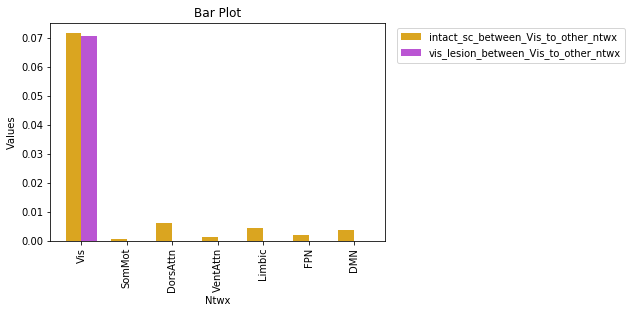

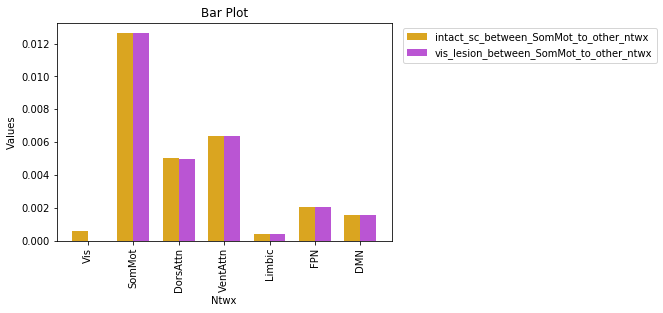

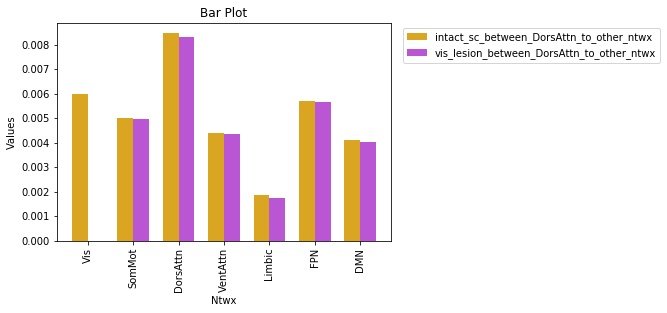

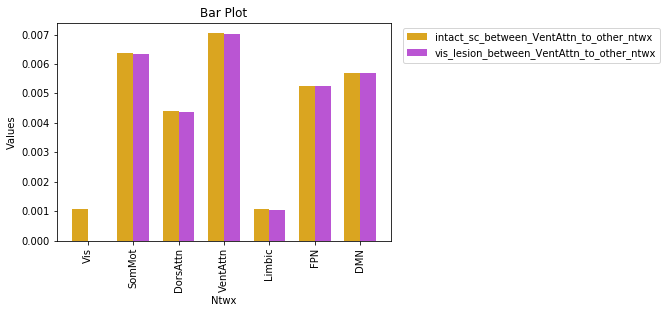

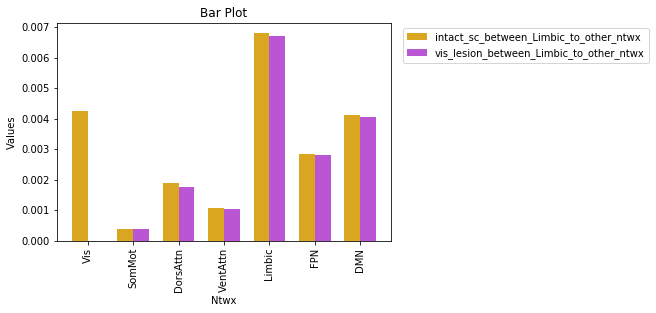

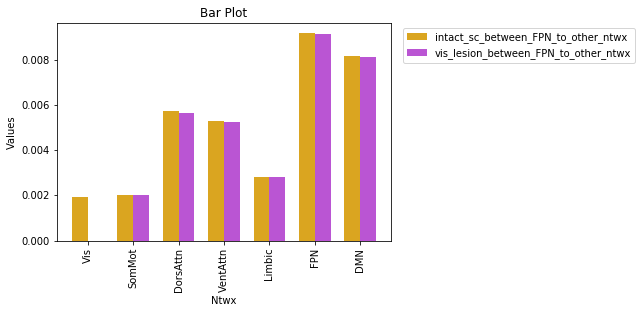

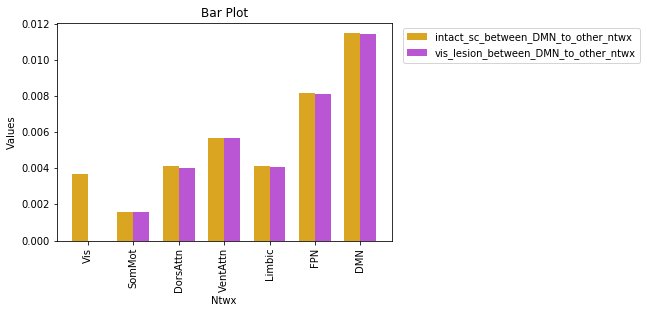

In [115]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], vis_lesion_between_other_ntwx[j], width, label='vis_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### SomatoMotor

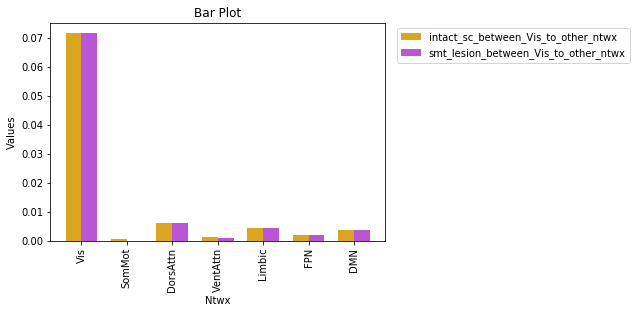

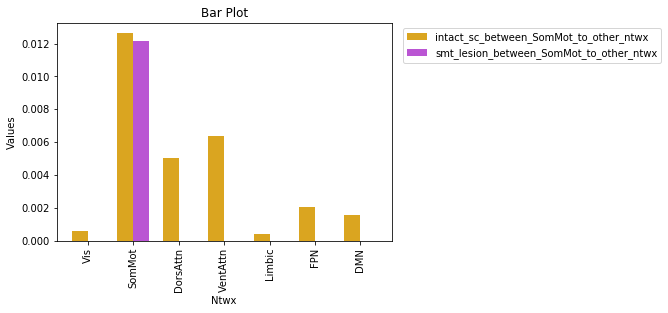

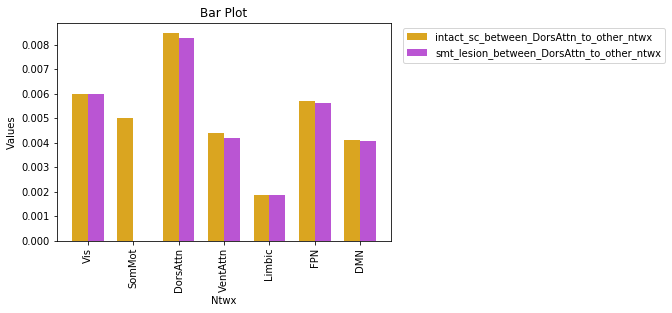

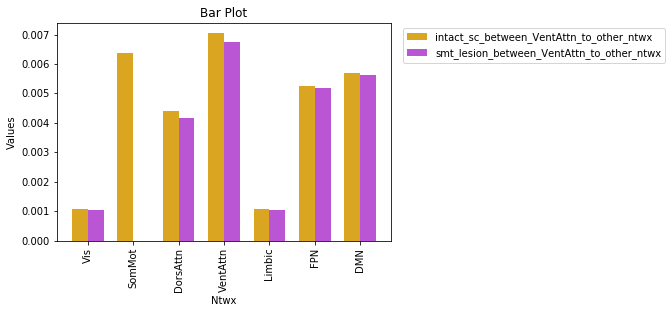

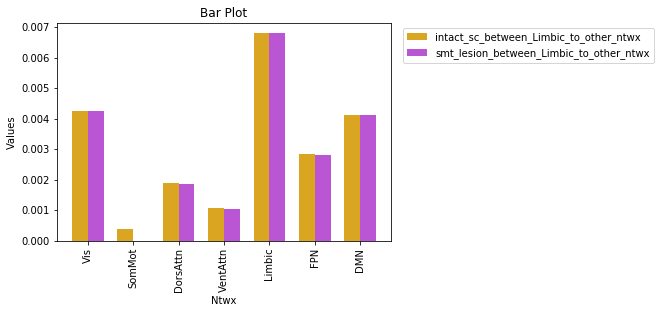

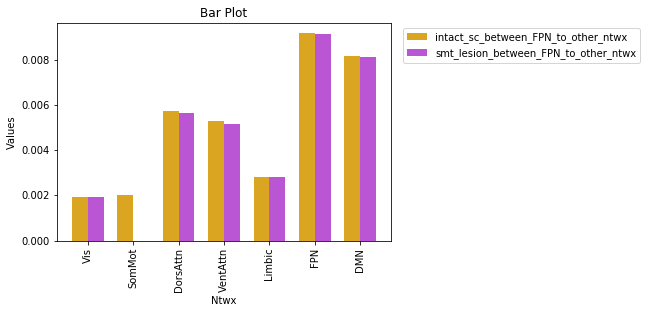

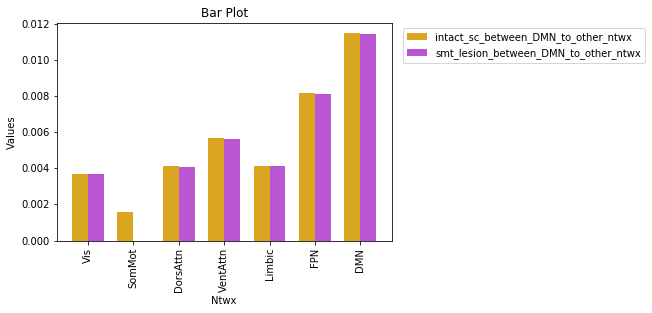

In [76]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], smt_lesion_between_other_ntwx[j], width, label='smt_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DAN

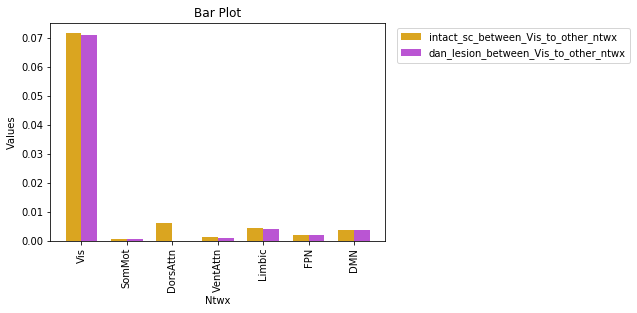

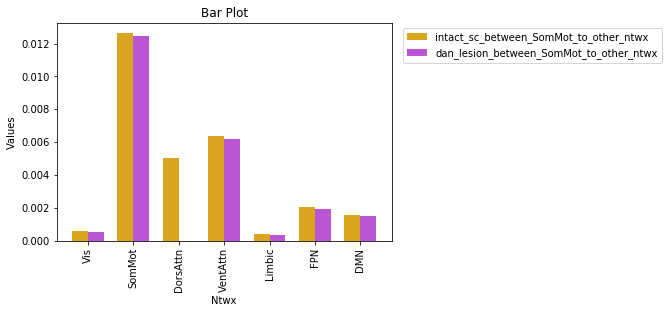

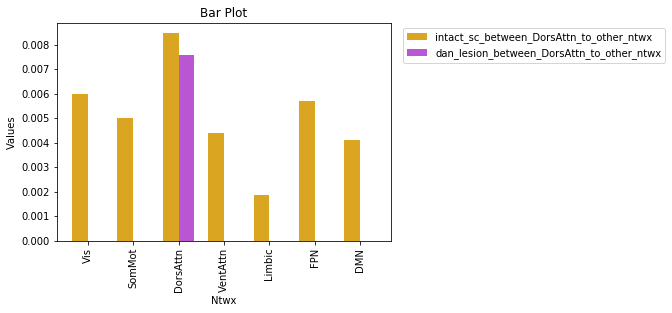

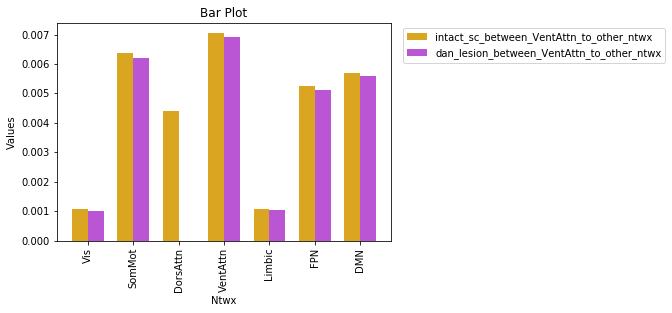

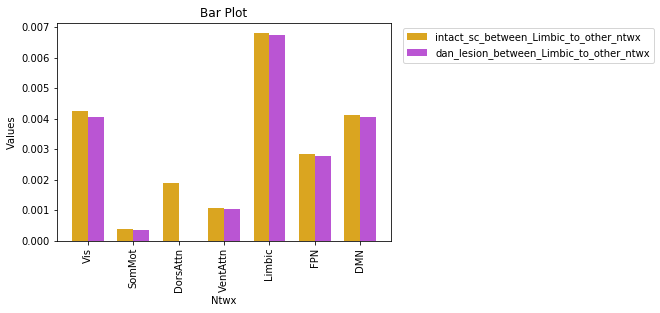

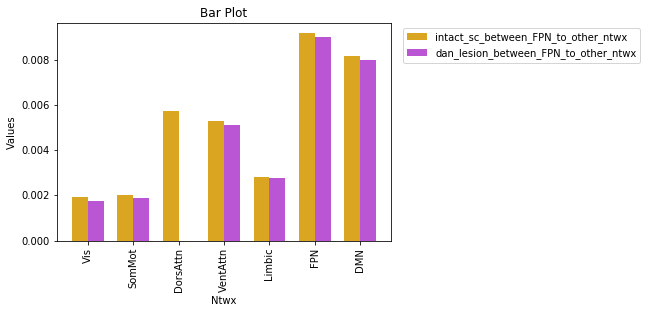

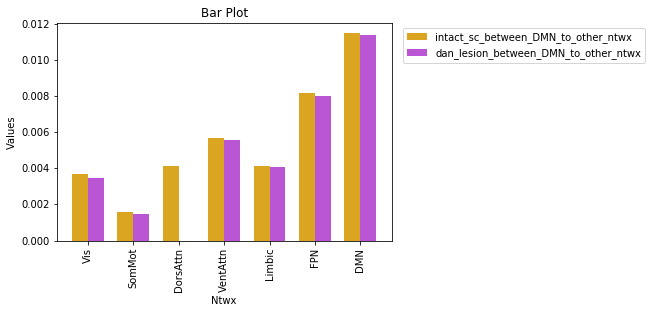

In [77]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], dan_lesion_between_other_ntwx[j], width, label='dan_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

In [147]:
van_lesion_between_other_ntwx

[array([0.0715115 , 0.00055459, 0.00598809, 0.        , 0.00425957,
        0.00191653, 0.00365118]),
 array([0.00055459, 0.01236037, 0.00482857, 0.        , 0.00035088,
        0.00188981, 0.0014322 ]),
 array([0.00598809, 0.00482857, 0.00836476, 0.        , 0.00186048,
        0.00559839, 0.00402346]),
 array([0.       , 0.       , 0.       , 0.0061779, 0.       , 0.       ,
        0.       ]),
 array([0.00425957, 0.00035088, 0.00186048, 0.        , 0.00679173,
        0.00280428, 0.00410348]),
 array([0.00191653, 0.00188981, 0.00559839, 0.        , 0.00280428,
        0.00895526, 0.00791588]),
 array([0.00365118, 0.0014322 , 0.00402346, 0.        , 0.00410348,
        0.00791588, 0.01125508])]

#### VAN

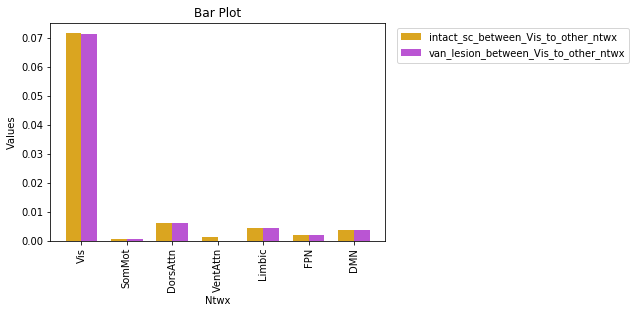

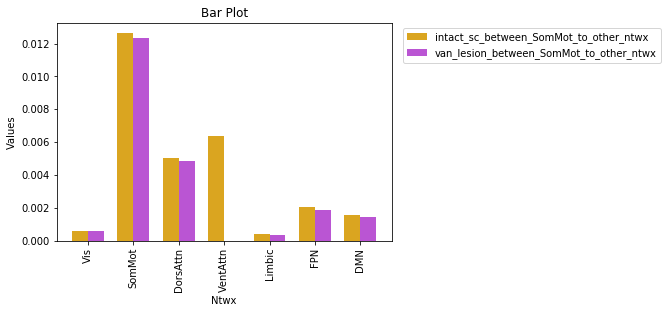

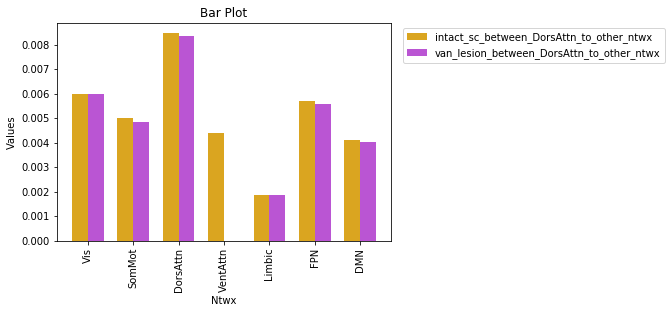

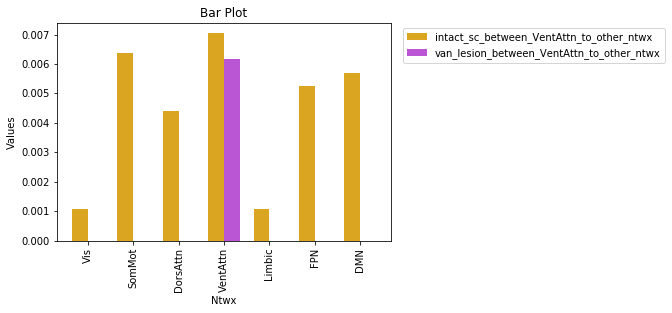

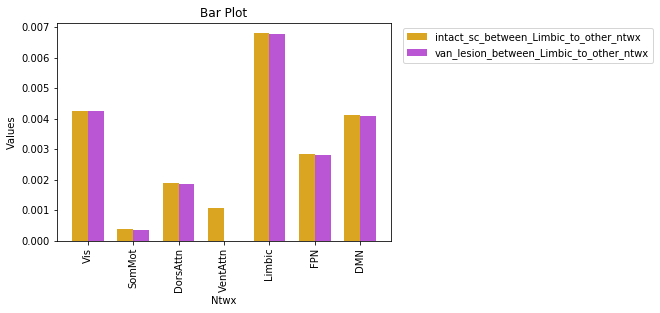

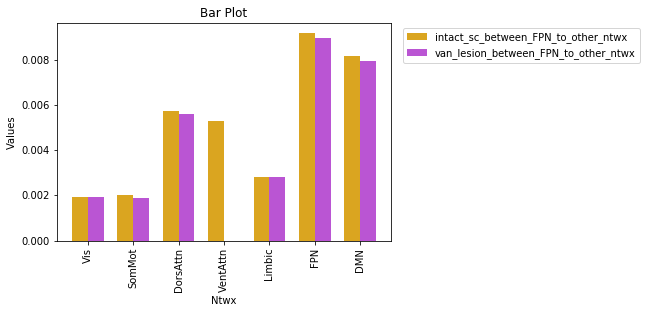

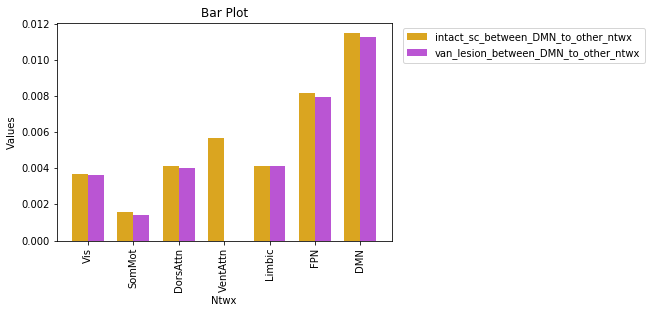

In [78]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], van_lesion_between_other_ntwx[j], width, label='van_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### lim

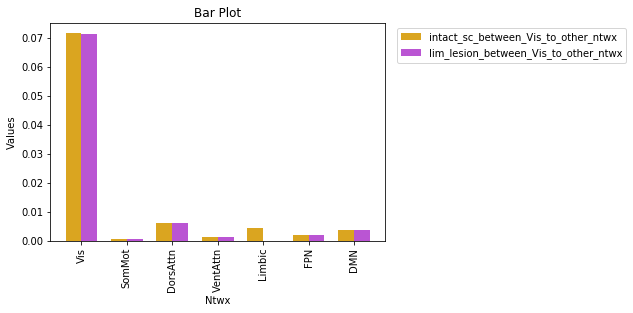

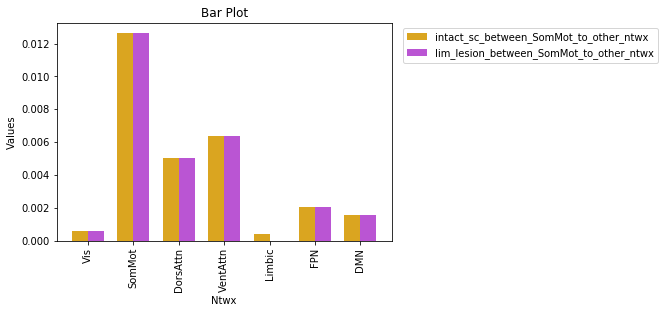

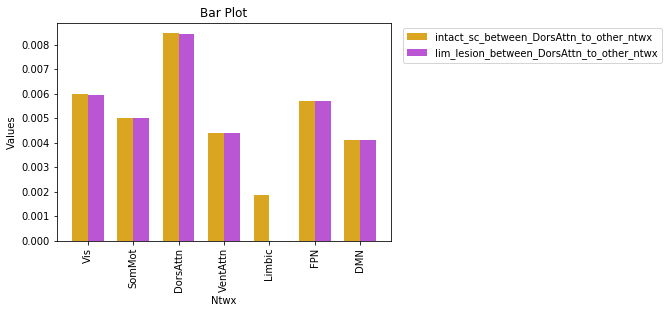

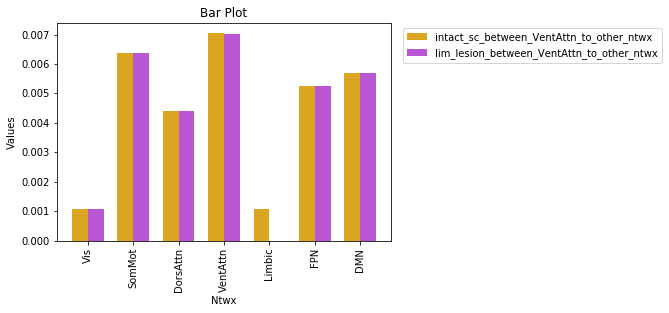

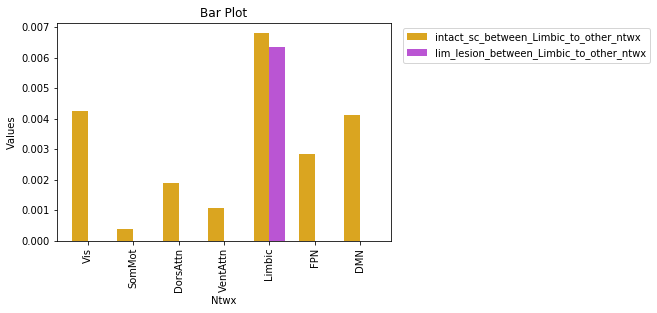

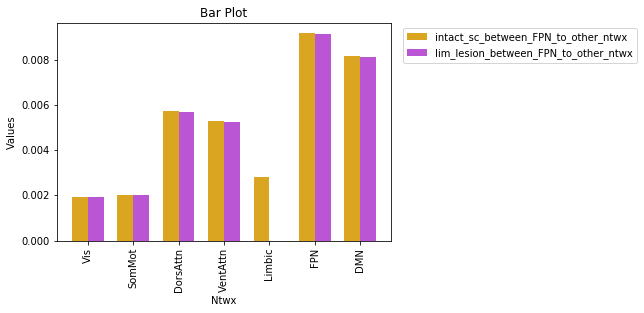

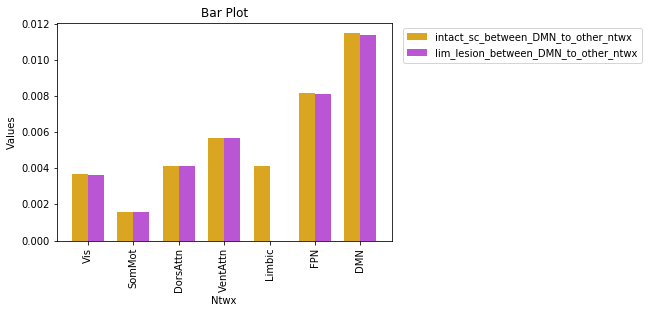

In [79]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], lim_lesion_between_other_ntwx[j], width, label='lim_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### FPN

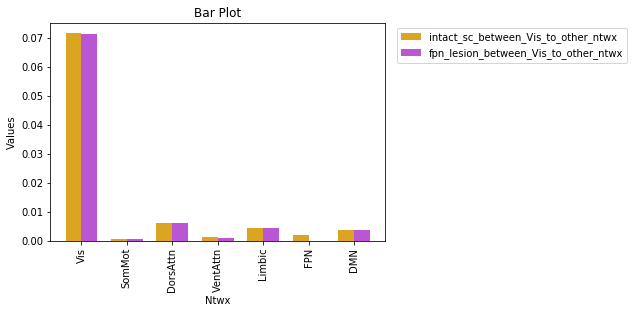

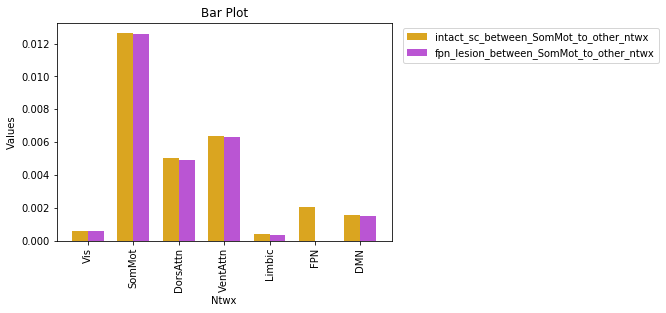

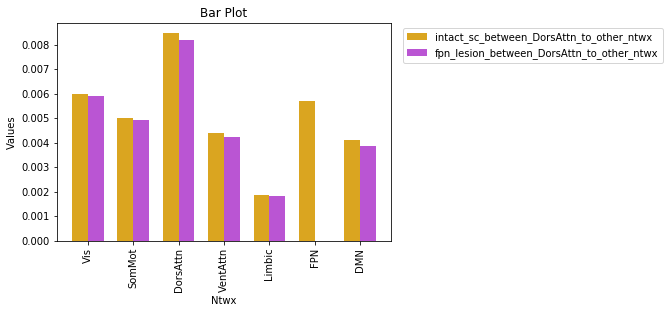

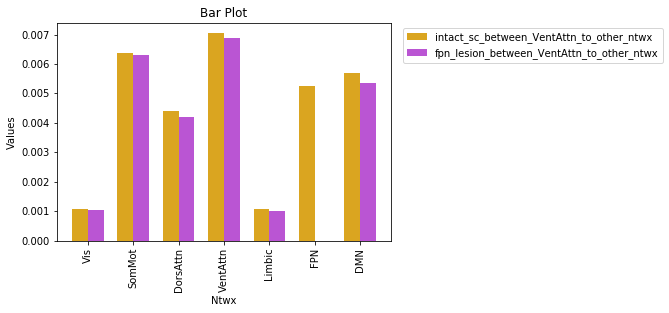

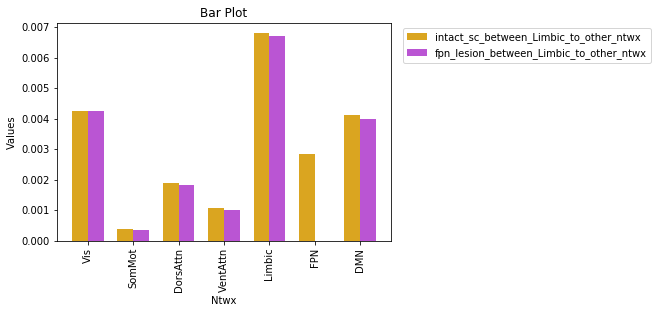

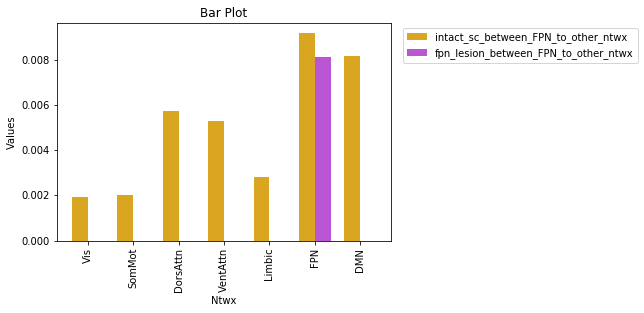

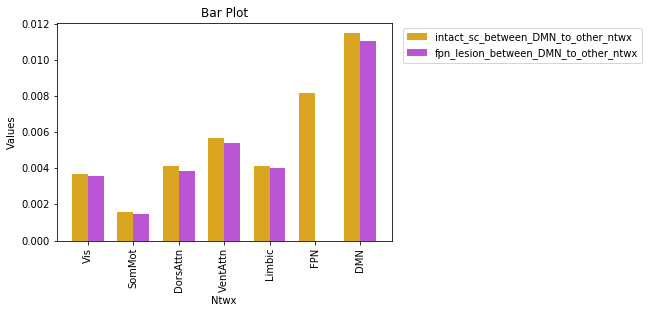

In [80]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], fpn_lesion_between_other_ntwx[j], width, label='fpn_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DMN

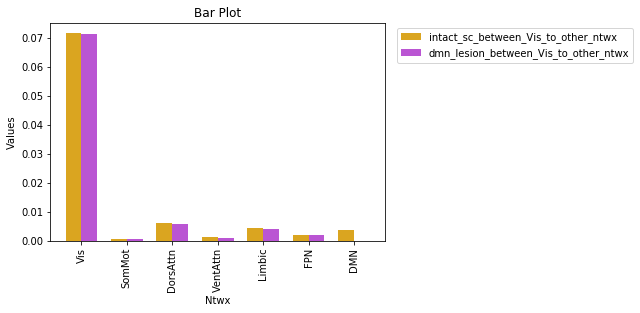

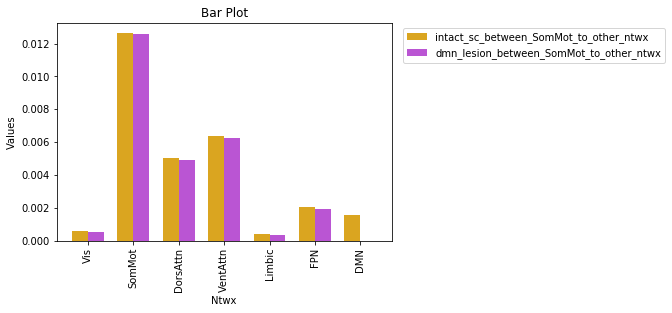

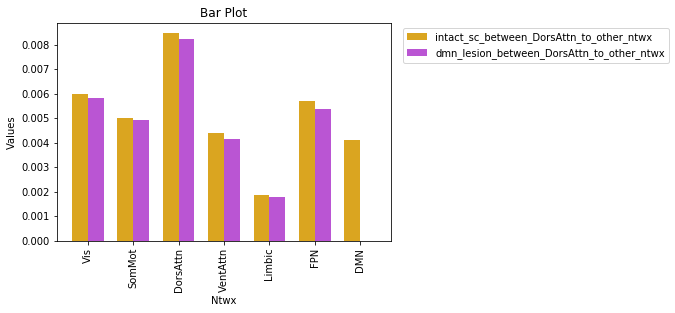

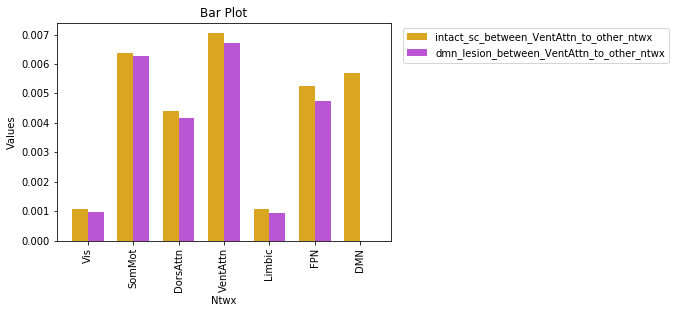

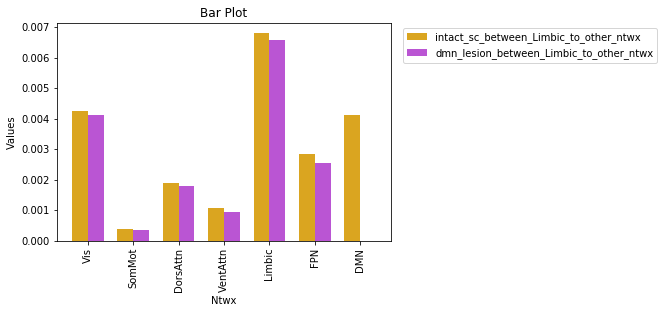

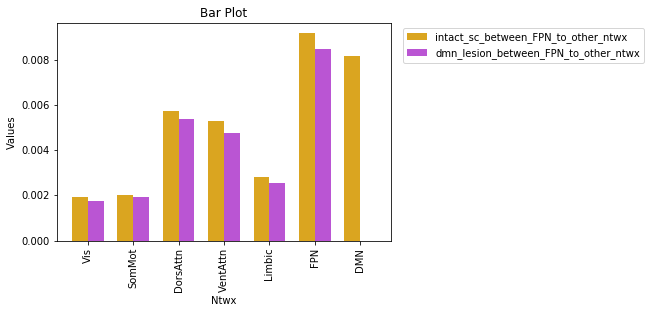

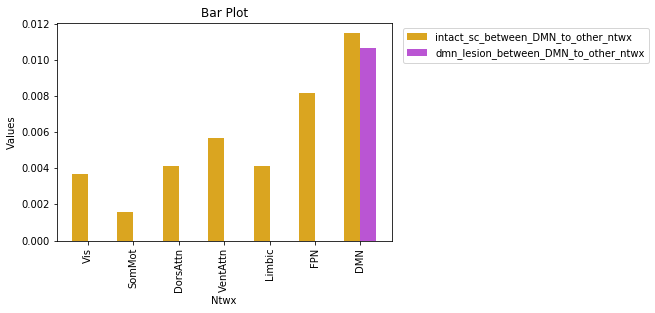

In [81]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='goldenrod')
    rects2 = ax.bar([i + width for i in x], dmn_lesion_between_other_ntwx[j], width, label='dmn_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='mediumorchid')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

## relationship with decrease in FC

In [154]:
# not means ... individual 7x7 values ...

def mean_percent_drops_all_vals(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
#     for j in range(7):
#         if j!=idx:
#             del percent_change_all_ntwx_lesion[j][idx]
    
       
    return percent_change_all_ntwx_lesion

In [155]:
sc_comm_all_ntwx = [vis_lesion_between_other_ntwx,smt_lesion_between_other_ntwx,dan_lesion_between_other_ntwx,
 van_lesion_between_other_ntwx,lim_lesion_between_other_ntwx,fpn_lesion_between_other_ntwx,
 dmn_lesion_between_other_ntwx]

In [156]:
percent_change_vis = mean_percent_drops_all_vals(vis_lesion_between_other_ntwx,0)
percent_change_smt = mean_percent_drops_all_vals(smt_lesion_between_other_ntwx,1)
percent_change_dan = mean_percent_drops_all_vals(dan_lesion_between_other_ntwx,2)
percent_change_van = mean_percent_drops_all_vals(van_lesion_between_other_ntwx,3)
percent_change_lim = mean_percent_drops_all_vals(lim_lesion_between_other_ntwx,4)
percent_change_fpn = mean_percent_drops_all_vals(fpn_lesion_between_other_ntwx,5)
percent_change_dmn = mean_percent_drops_all_vals(dmn_lesion_between_other_ntwx,6)

In [157]:
percent_change_all_ntwx_all_vals = [percent_change_vis,percent_change_smt,percent_change_dan,
                                    percent_change_van,percent_change_lim,percent_change_fpn,
                                    percent_change_dmn]

In [159]:
def outer_ntwx_only_fc(fc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_fc = ((np.mean(lh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/2 + (np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis))/2)
    mean_ntwx_to_sommot_fc = ((np.mean(lh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))/2 + (np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot))/2)
    mean_ntwx_to_dorsattn_fc = ((np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))/2 + (np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn))/2)
    mean_ntwx_to_ventattn_fc = ((np.mean(lh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))/2 + (np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn))/2)
    mean_ntwx_to_limbic_fc = ((np.mean(lh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))/2 + (np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic))/2)
    mean_ntwx_to_fpn_fc = ((np.mean(lh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/2 + (np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn))/2)
    mean_ntwx_to_dmn_fc = ((np.mean(lh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/2 + (np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn))/2)
    
    
    return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
    

In [160]:
%%time

all_subs_vis_to_other_ntwx = []
all_subs_sommot_to_other_ntwx = []
all_subs_dorsattn_to_other_ntwx = []
all_subs_ventattn_to_other_ntwx = []
all_subs_limbic_to_other_ntwx = []
all_subs_fpn_to_other_ntwx = []
all_subs_dmn_to_other_ntwx = []

for i in range(200):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,0)
    all_subs_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,1)
    all_subs_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,2)
    all_subs_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,3)
    all_subs_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,4)
    all_subs_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,5)
    all_subs_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,6)
    all_subs_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 892 ms, sys: 0 ns, total: 892 ms
Wall time: 883 ms


In [161]:
og_whobpyt_vis_to_other_ntwx = np.mean(all_subs_vis_to_other_ntwx,axis=0)
og_whobpyt_sommot_to_other_ntwx = np.mean(all_subs_sommot_to_other_ntwx,axis=0)
og_whobpyt_dorsattn_to_other_ntwx = np.mean(all_subs_dorsattn_to_other_ntwx,axis=0)
og_whobpyt_ventattn_to_other_ntwx = np.mean(all_subs_ventattn_to_other_ntwx,axis=0)
og_whobpyt_limbic_to_other_ntwx = np.mean(all_subs_limbic_to_other_ntwx,axis=0)
og_whobpyt_fpn_to_other_ntwx = np.mean(all_subs_fpn_to_other_ntwx,axis=0)
og_whobpyt_dmn_to_other_ntwx = np.mean(all_subs_dmn_to_other_ntwx,axis=0)

In [171]:
# Across all 200 subs
og_whobpyt_outer_to_other_ntwx  = [og_whobpyt_vis_to_other_ntwx,og_whobpyt_sommot_to_other_ntwx,
                                   og_whobpyt_dorsattn_to_other_ntwx,og_whobpyt_ventattn_to_other_ntwx,
                                   og_whobpyt_limbic_to_other_ntwx,og_whobpyt_fpn_to_other_ntwx,
                                   og_whobpyt_dmn_to_other_ntwx]

In [163]:
def get_outer_ntwx_fc(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_sommot_to_other_ntwx_lesions = np.mean(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dorsattn_to_other_ntwx_lesions = np.mean(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_ventattn_to_other_ntwx_lesions = np.mean(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_limbic_to_other_ntwx_lesions = np.mean(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_sommot_to_other_ntwx_lesions,mean_all_subs_dorsattn_to_other_ntwx_lesions,mean_all_subs_ventattn_to_other_ntwx_lesions,mean_all_subs_limbic_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [164]:
def get_outer_ntwx_fc_all_subs(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    return all_subs_vis_to_other_ntwx_lesions,all_subs_sommot_to_other_ntwx_lesions,all_subs_dorsattn_to_other_ntwx_lesions,all_subs_ventattn_to_other_ntwx_lesions,all_subs_limbic_to_other_ntwx_lesions,all_subs_fpn_to_other_ntwx_lesions,all_subs_dmn_to_other_ntwx_lesions

In [168]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_vis_to_other_ntwx_fc, vis_lesion_sommot_to_other_ntwx_fc, vis_lesion_dorsattn_to_other_ntwx_fc, vis_lesion_ventattn_to_other_ntwx_fc, vis_lesion_limbic_to_other_ntwx_fc, vis_lesion_fpn_to_other_ntwx_fc, vis_lesion_dmn_to_other_ntwx_fc = get_outer_ntwx_fc(all_subs_vis_lesion)

sommot_lesion_vis_to_other_ntwx_fc, sommot_lesion_sommot_to_other_ntwx_fc, sommot_lesion_dorsattn_to_other_ntwx_fc, sommot_lesion_ventattn_to_other_ntwx_fc, sommot_lesion_limbic_to_other_ntwx_fc, sommot_lesion_fpn_to_other_ntwx_fc, sommot_lesion_dmn_to_other_ntwx_fc = get_outer_ntwx_fc(all_subs_sommot_lesion)

dorsattn_lesion_vis_to_other_ntwx_fc, dorsattn_lesion_sommot_to_other_ntwx_fc, dorsattn_lesion_dorsattn_to_other_ntwx_fc, dorsattn_lesion_ventattn_to_other_ntwx_fc, dorsattn_lesion_limbic_to_other_ntwx_fc, dorsattn_lesion_fpn_to_other_ntwx_fc, dorsattn_lesion_dmn_to_other_ntwx_fc = get_outer_ntwx_fc(all_subs_dorsattn_lesion)

ventattn_lesion_vis_to_other_ntwx_fc, ventattn_lesion_sommot_to_other_ntwx_fc, ventattn_lesion_dorsattn_to_other_ntwx_fc, ventattn_lesion_ventattn_to_other_ntwx_fc, ventattn_lesion_limbic_to_other_ntwx_fc, ventattn_lesion_fpn_to_other_ntwx_fc, ventattn_lesion_dmn_to_other_ntwx_fc = get_outer_ntwx_fc(all_subs_ventattn_lesion)

limbic_lesion_vis_to_other_ntwx_fc, limbic_lesion_sommot_to_other_ntwx_fc, limbic_lesion_dorsattn_to_other_ntwx_fc, limbic_lesion_ventattn_to_other_ntwx_fc, limbic_lesion_limbic_to_other_ntwx_fc, limbic_lesion_fpn_to_other_ntwx_fc, limbic_lesion_dmn_to_other_ntwx_fc = get_outer_ntwx_fc(all_subs_limbic_lesion)

fpn_lesion_vis_to_other_ntwx_fc, fpn_lesion_sommot_to_other_ntwx_fc, fpn_lesion_dorsattn_to_other_ntwx_fc, fpn_lesion_ventattn_to_other_ntwx_fc, fpn_lesion_limbic_to_other_ntwx_fc, fpn_lesion_fpn_to_other_ntwx_fc, fpn_lesion_dmn_to_other_ntwx_fc = get_outer_ntwx_fc(all_subs_fpn_lesion)

dmn_lesion_vis_to_other_ntwx_fc, dmn_lesion_sommot_to_other_ntwx_fc, dmn_lesion_dorsattn_to_other_ntwx_fc, dmn_lesion_ventattn_to_other_ntwx_fc, dmn_lesion_limbic_to_other_ntwx_fc, dmn_lesion_fpn_to_other_ntwx_fc, dmn_lesion_dmn_to_other_ntwx_fc = get_outer_ntwx_fc(all_subs_dmn_lesion)


CPU times: user 5.99 s, sys: 0 ns, total: 5.99 s
Wall time: 5.97 s


In [169]:
vis_lesion_outer_to_other_ntwx_fc = [vis_lesion_vis_to_other_ntwx_fc, vis_lesion_sommot_to_other_ntwx_fc, vis_lesion_dorsattn_to_other_ntwx_fc, vis_lesion_ventattn_to_other_ntwx_fc, vis_lesion_limbic_to_other_ntwx_fc, vis_lesion_fpn_to_other_ntwx_fc, vis_lesion_dmn_to_other_ntwx_fc]
sommot_lesion_outer_to_other_ntwx_fc = [sommot_lesion_vis_to_other_ntwx_fc, sommot_lesion_sommot_to_other_ntwx_fc, sommot_lesion_dorsattn_to_other_ntwx_fc, sommot_lesion_ventattn_to_other_ntwx_fc, sommot_lesion_limbic_to_other_ntwx_fc, sommot_lesion_fpn_to_other_ntwx_fc, sommot_lesion_dmn_to_other_ntwx_fc]
dorsattn_lesion_outer_to_other_ntwx_fc = [dorsattn_lesion_vis_to_other_ntwx_fc, dorsattn_lesion_sommot_to_other_ntwx_fc, dorsattn_lesion_dorsattn_to_other_ntwx_fc, dorsattn_lesion_ventattn_to_other_ntwx_fc, dorsattn_lesion_limbic_to_other_ntwx_fc, dorsattn_lesion_fpn_to_other_ntwx_fc, dorsattn_lesion_dmn_to_other_ntwx_fc]
ventattn_lesion_outer_to_other_ntwx_fc = [ventattn_lesion_vis_to_other_ntwx_fc, ventattn_lesion_sommot_to_other_ntwx_fc, ventattn_lesion_dorsattn_to_other_ntwx_fc, ventattn_lesion_ventattn_to_other_ntwx_fc, ventattn_lesion_limbic_to_other_ntwx_fc, ventattn_lesion_fpn_to_other_ntwx_fc, ventattn_lesion_dmn_to_other_ntwx_fc]
limbic_lesion_outer_to_other_ntwx_fc = [limbic_lesion_vis_to_other_ntwx_fc, limbic_lesion_sommot_to_other_ntwx_fc, limbic_lesion_dorsattn_to_other_ntwx_fc, limbic_lesion_ventattn_to_other_ntwx_fc, limbic_lesion_limbic_to_other_ntwx_fc, limbic_lesion_fpn_to_other_ntwx_fc, limbic_lesion_dmn_to_other_ntwx_fc]
fpn_lesion_outer_to_other_ntwx_fc = [fpn_lesion_vis_to_other_ntwx_fc, fpn_lesion_sommot_to_other_ntwx_fc, fpn_lesion_dorsattn_to_other_ntwx_fc, fpn_lesion_ventattn_to_other_ntwx_fc, fpn_lesion_limbic_to_other_ntwx_fc, fpn_lesion_fpn_to_other_ntwx_fc, fpn_lesion_dmn_to_other_ntwx_fc]
dmn_lesion_outer_to_other_ntwx_fc = [dmn_lesion_vis_to_other_ntwx_fc, dmn_lesion_sommot_to_other_ntwx_fc, dmn_lesion_dorsattn_to_other_ntwx_fc, dmn_lesion_ventattn_to_other_ntwx_fc, dmn_lesion_limbic_to_other_ntwx_fc, dmn_lesion_fpn_to_other_ntwx_fc, dmn_lesion_dmn_to_other_ntwx_fc]

In [172]:
og_whobpyt_outer_to_other_ntwx = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx]

In [173]:
vis_lesion_outer_to_other_ntwx_fc = [arr.tolist() for arr in vis_lesion_outer_to_other_ntwx_fc]
sommot_lesion_outer_to_other_ntwx_fc = [arr.tolist() for arr in sommot_lesion_outer_to_other_ntwx_fc]
dorsattn_lesion_outer_to_other_ntwx_fc = [arr.tolist() for arr in dorsattn_lesion_outer_to_other_ntwx_fc]
ventattn_lesion_outer_to_other_ntwx_fc = [arr.tolist() for arr in ventattn_lesion_outer_to_other_ntwx_fc]
limbic_lesion_outer_to_other_ntwx_fc = [arr.tolist() for arr in limbic_lesion_outer_to_other_ntwx_fc]
fpn_lesion_outer_to_other_ntwx_fc = [arr.tolist() for arr in fpn_lesion_outer_to_other_ntwx_fc]
dmn_lesion_outer_to_other_ntwx_fc = [arr.tolist() for arr in dmn_lesion_outer_to_other_ntwx_fc]

In [176]:
# not means ... individual 7x7 values ...

def mean_percent_drops_all_vals_fc(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(og_whobpyt_outer_to_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
#     for j in range(7):
#         if j!=idx:
#             del percent_change_all_ntwx_lesion[j][idx]
    
       
    return percent_change_all_ntwx_lesion

In [177]:
percent_change_vis_fc = mean_percent_drops_all_vals_fc(vis_lesion_outer_to_other_ntwx_fc,0)
percent_change_smt_fc = mean_percent_drops_all_vals_fc(sommot_lesion_outer_to_other_ntwx_fc,1)
percent_change_dan_fc = mean_percent_drops_all_vals_fc(dorsattn_lesion_outer_to_other_ntwx_fc,2)
percent_change_van_fc = mean_percent_drops_all_vals_fc(ventattn_lesion_outer_to_other_ntwx_fc,3)
percent_change_lim_fc = mean_percent_drops_all_vals_fc(limbic_lesion_outer_to_other_ntwx_fc,4)
percent_change_fpn_fc = mean_percent_drops_all_vals_fc(fpn_lesion_outer_to_other_ntwx_fc,5)
percent_change_dmn_fc = mean_percent_drops_all_vals_fc(dmn_lesion_outer_to_other_ntwx_fc,6)

In [178]:
percent_change_all_ntwx_all_vals_fc = [percent_change_vis_fc,percent_change_smt_fc,percent_change_dan_fc,
                                    percent_change_van_fc,percent_change_lim_fc,percent_change_fpn_fc,
                                    percent_change_dmn_fc]

In [190]:
print(percent_change_all_ntwx_all_vals[0][0])

print(percent_change_all_ntwx_all_vals_fc[0][0])

[-1.1516130432049743, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]
[-7.204290046660875, -100.41106908836335, -100.37337536310977, -100.21918263431009, -106.49439101507829, -98.1729014945464, -97.85126443951116]


### vis lesion
#### % change in sc comm correlation with % change in average fc 

In [207]:
for i in range(7):
    if i !=0:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[0][i][0:4], percent_change_all_ntwx_all_vals_fc[0][i][0:4])[0][1]
#         b = b*100
        print(np.round(b,5))

0.98844
0.99781
0.99397
0.99603
0.99775
0.99378


In [208]:
for i in range(7):
    if i !=0:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[0][i][4:7], percent_change_all_ntwx_all_vals_fc[0][i][4:7])[0][1]
#         b = b*100
        print(np.round(b,5))

-0.39435
0.29882
-0.63653
-0.64688
-0.94406
-0.96875


### smt lesion
#### % change in sc comm correlation with % change in average fc 

In [212]:
idx = 1

In [209]:
for i in range(7):
    if i !=idx:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[idx][i][0:4], percent_change_all_ntwx_all_vals_fc[idx][i][0:4])[0][1]
#         b = b*100
        print(np.round(b,5))

0.99951
0.99991
0.99984
0.99981
0.99984
0.99993


In [213]:
for i in range(7):
    if i !=idx:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[idx][i][4:7], percent_change_all_ntwx_all_vals_fc[idx][i][4:7])[0][1]
#         b = b*100
        print(np.round(b,5))

0.16826
0.28675
-0.86602
-0.8235
0.95129
0.87227


### dan lesion 
#### % change in sc comm correlation with % change in average fc 

In [214]:
idx = 2

In [215]:
for i in range(7):
    if i !=idx:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[idx][i][0:4], percent_change_all_ntwx_all_vals_fc[idx][i][0:4])[0][1]
#         b = b*100
        print(np.round(b,5))

0.99606
0.99676
0.99764
0.99511
0.99904
0.99972


In [216]:
for i in range(7):
    if i !=idx:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[idx][i][4:7], percent_change_all_ntwx_all_vals_fc[idx][i][4:7])[0][1]
#         b = b*100
        print(np.round(b,5))

0.82349
0.71763
0.24887
-0.7657
-0.93472
0.1362


### van lesion 
#### % change in sc comm correlation with % change in average fc 

In [222]:
idx = 3

In [223]:
for i in range(7):
    if i !=idx:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[idx][i][0:4], percent_change_all_ntwx_all_vals_fc[idx][i][0:4])[0][1]
#         b = b*100
        print(np.round(b,5))

0.99906
0.99763
0.999
0.99811
0.99965
0.99898


In [224]:
for i in range(7):
    if i !=idx:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[idx][i][4:7], percent_change_all_ntwx_all_vals_fc[idx][i][4:7])[0][1]
#         b = b*100
        print(np.round(b,5))

-0.0814
-0.85475
-0.16849
0.13228
-0.59237
0.972


### lim lesion 
#### % change in sc comm correlation with % change in average fc 

In [225]:
idx = 4

In [226]:
for i in range(7):
    if i !=idx:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[idx][i][0:4], percent_change_all_ntwx_all_vals_fc[idx][i][0:4])[0][1]
#         b = b*100
        print(np.round(b,5))

0.59503
0.91094
-0.05323
0.62338
-0.3775
0.10781


In [227]:
for i in range(7):
    if i !=idx:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[idx][i][4:7], percent_change_all_ntwx_all_vals_fc[idx][i][4:7])[0][1]
#         b = b*100
        print(np.round(b,5))

0.99988
0.99991
0.99988
0.99997
0.99999
0.99999


### fpn lesion
#### % change in sc comm correlation with % change in average fc 

In [241]:
idx = 5

In [242]:
for i in range(7):
    if i !=idx:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[idx][i][0:4], percent_change_all_ntwx_all_vals_fc[idx][i][0:4])[0][1]
#         b = b*100
        print(np.round(b,5))

0.91991
0.36053
0.94812
0.73389
0.28896
0.8182


In [243]:
for i in range(7):
    if i !=idx:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[idx][i][4:7], percent_change_all_ntwx_all_vals_fc[idx][i][4:7])[0][1]
#         b = b*100
        print(np.round(b,5))

0.99801
0.99785
0.99941
0.99645
0.99886
0.99973


### dmn lesion
#### % change in sc comm correlation with % change in average fc 

In [244]:
idx = 6

In [245]:
for i in range(7):
    if i !=idx:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[idx][i][0:4], percent_change_all_ntwx_all_vals_fc[idx][i][0:4])[0][1]
#         b = b*100
        print(np.round(b,5))

0.01828
0.1839
-0.0002
0.18706
-0.04307
0.9314


In [246]:
for i in range(7):
    if i !=idx:
        b = np.corrcoef(percent_change_all_ntwx_all_vals[idx][i][4:7], percent_change_all_ntwx_all_vals_fc[idx][i][4:7])[0][1]
#         b = b*100
        print(np.round(b,5))

0.99184
0.99931
0.99806
0.99953
0.98063
0.96915
